In [41]:
import sys
import numpy as np
import pandas as pd
import re,sys,nltk
import seaborn as sns
import matplotlib. pyplot as plt
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,f1_score
from IPython.display import display
from wordcloud import WordCloud

In [51]:
train=pd.read_csv('train_E6oV3lV.csv')
test=pd.read_csv('test_tweets_anuFYb8.csv')
final = train.append(test, ignore_index=True,sort=True)

In [43]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)    
    return input_txt

In [52]:
# removal of @user from the texts
final['cleantweet']=np.vectorize(remove_pattern)(final['tweet'],'@[\w]*')
final['cleantweet']=np.vectorize(remove_pattern)(final['cleantweet'],'<[^>]*>')
# removal of all special characters except hastags and other special characters
final['cleantweet'] =final['cleantweet'].str.replace('[^a-zA-Z#]', ' ')
# removal of short words and lower case conversion
final['cleantweet']=final['cleantweet'].apply(lambda x : ' '.join([w.lower() for w in x.split(' ') if len(w)>3]))
# removal of stop words
stop_words = set(stopwords.words('english'))
final['cleantweet']=final['cleantweet'].apply(lambda x : ' '.join([w for w in x.split(' ') if not w in stop_words]))

In [53]:
# tokenization
tokenized_tweet = final['cleantweet'].apply(lambda x: x.split(' '))
tokenized_tweet.head()

0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, cause, offer, wheelcha...
2                                    [bihday, majesty]
3                           [#model, love, take, time]
4                   [factsguide, society, #motivation]
Name: cleantweet, dtype: object

In [55]:
# lemmatization
#ls=WordNetLemmatizer()
#tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="n") for i in x]) # lemmatize for noun
#tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="a") for i in x]) # lemmatize for adjective
#tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="r") for i in x]) # lemmatize for adverb
#tokenized_tweet = tokenized_tweet.apply(lambda x: [ls.lemmatize(i,pos="v") for i in x]) # lemmatize for verb
# stemming
ps = SnowballStemmer("english")
tokenized_tweet = tokenized_tweet.apply(lambda x: [ps.stem(i) for i in x]) # lemmatize for noun
for i in range(len(tokenized_tweet)):
        tokenized_tweet[i]=' '.join(tokenized_tweet[i])
final['cleantweet']=tokenized_tweet
tokenized_tweet.head()

0       father dysfunct selfish drag kid dysfunct #run
1    thank #lyft credit caus offer wheelchair van #...
2                                       bihday majesti
3                                #model love take time
4                             factsguid societi #motiv
Name: cleantweet, dtype: object

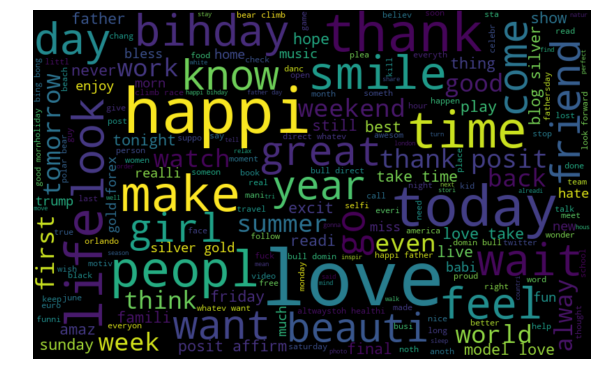

In [28]:
# Understanding common word use dion tweet
all_words=' '.join([text for text in final['cleantweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

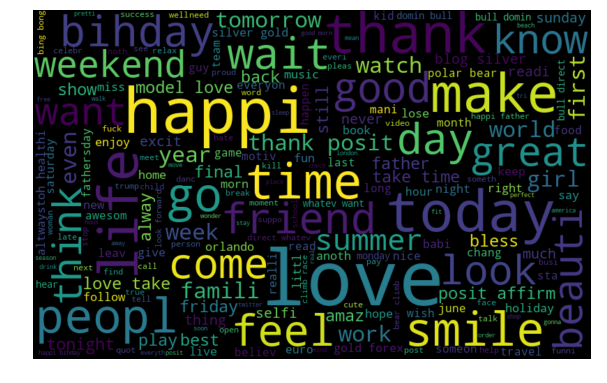

In [8]:
# gathering all non-racist/non-sexist words
normal_words=' '.join([text for text in final['cleantweet'][final['label']==0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

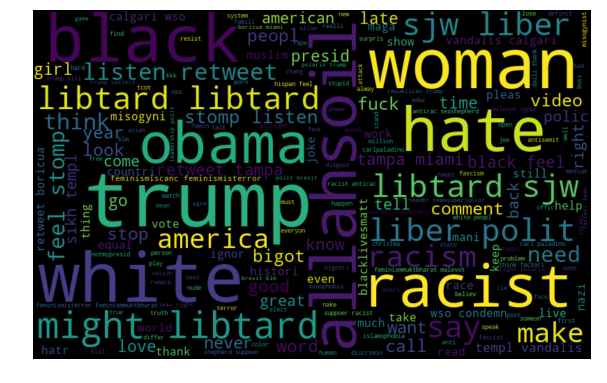

In [9]:
# gathering all racist/sexist words
racist_words=' '.join([text for text in final['cleantweet'][final['label']==1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(racist_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [10]:
# understanding importance of hashtags
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(final['cleantweet'][final['label']==0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(final['cleantweet'][final['label']==1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])
HT_regular

['run',
 'lyft',
 'disapoint',
 'getthank',
 'model',
 'motiv',
 'allshowandnogo',
 'school',
 'exam',
 'hate',
 'imagin',
 'actorslif',
 'revolutionschool',
 'girl',
 'allin',
 'cav',
 'champion',
 'cleveland',
 'clevelandcavali',
 'ireland',
 'blog',
 'silver',
 'gold',
 'forex',
 'orlando',
 'standwithorlando',
 'pulseshoot',
 'orlandoshoot',
 'biggerproblem',
 'selfish',
 'heabreak',
 'valu',
 'love',
 'gettingf',
 'got',
 'junior',
 'yugyoem',
 'omg',
 'thank',
 'posit',
 'friday',
 'cooki',
 'euro',
 'badday',
 'coneofsham',
 'cat',
 'piss',
 'funni',
 'laugh',
 'wine',
 'weekend',
 'tgif',
 'gamedev',
 'indiedev',
 'indiegamedev',
 'squad',
 'upsideofflorida',
 'shopalyssa',
 'love',
 'smile',
 'media',
 'pressconfer',
 'antalya',
 'turkey',
 'throwback',
 'ica',
 'rip',
 'orlando',
 'alohafriday',
 'time',
 'not',
 'exist',
 'positivevib',
 'hawaiian',
 'goodnight',
 'badmonday',
 'taylorswift',
 'travelingram',
 'dalat',
 'ripinkylif',
 'photoshop',
 'enoughisenough',
 'dontph

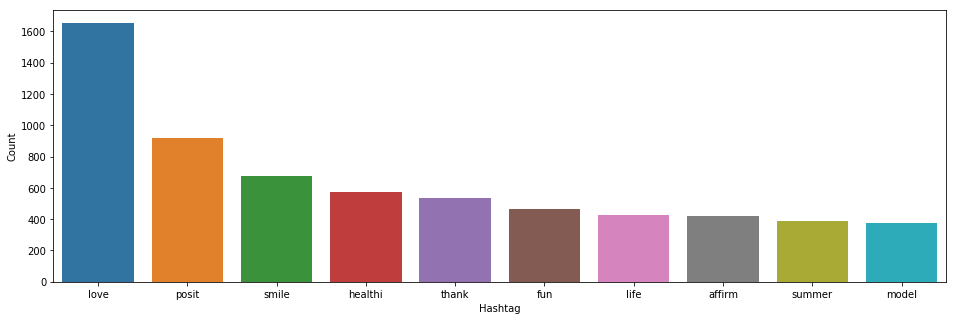

In [11]:
# plotting non-racist tweets
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

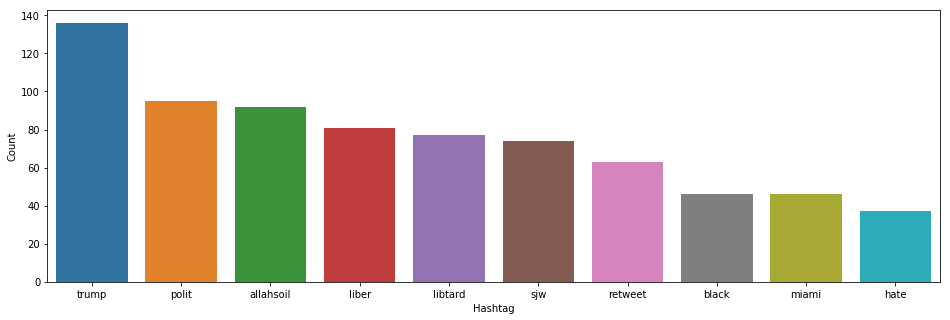

In [12]:
# plotting racist tweets
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [56]:
#countvectorizer
count_vectorizer = CountVectorizer(stop_words='english')
# count matrix
count_matrix = count_vectorizer.fit_transform(final['cleantweet'])
#tfidftransformer
#tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
transformer=TfidfTransformer(norm='l2',sublinear_tf=True)
# TF-IDF feature matrix
tfidf = transformer.fit_transform(count_matrix)


In [57]:
train_tfidf = tfidf[:31962]
test_tfidf = tfidf[31962:]
# splitting data into training and validation set
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(train_tfidf, train['label'], random_state=42, test_size=0.3)


model_name
LinearSVC                 0.961426
LogisticRegression        0.946900
MultinomialNB             0.936084
RandomForestClassifier    0.930363
Name: accuracy, dtype: float64

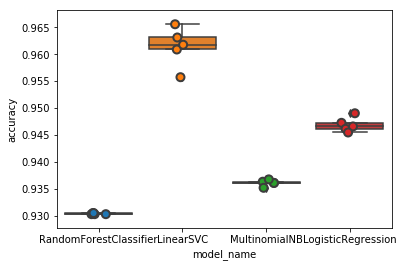

In [58]:
# using tfidf
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, xtrain_tfidf, ytrain_tfidf, scoring='accuracy', cv=CV) 
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
cv_df.groupby('model_name').accuracy.mean()

In [59]:
# best performing model is LinearSVC                 
model=LinearSVC()
clf=model.fit(xtrain_tfidf,ytrain_tfidf)
y_pred = clf.predict(xvalid_tfidf) # predicting on the validation set
print(f1_score(yvalid_tfidf, y_pred, average='weighted') )

0.9569870408548029


In [33]:
prediction = clf.predict(test_tfidf) # predicting on the validation set
test_pred_int = prediction.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]

In [54]:
submission.to_csv('test_predictions.csv',index=False)